Import Libraries

In [1]:
import os
import sys
import requests
import pandas as pd
import numpy as np
from IPython.display import display
from time import sleep
from tqdm import tqdm
import json
import re
import bson
from py2neo import Graph, Node, Relationship
from py2neo.matching import *

Connection to Database

In [2]:
graph = Graph('bolt://localhost:7687',password='0000')

In [3]:
#data = bson.decode_file_iter(open('citizenScience/action/citizenScience.bson','rb'))
#df = pd.DataFrame(data)

In [4]:
#df.to_csv('TwitterDataV2.csv')

Load the CSV file

In [5]:
df = pd.read_csv(r'\Users\vasil\Downloads\TwitterData.csv')

In [6]:
#Drop dublicates
tweets = df.drop_duplicates(subset=['id'])

In [7]:
tweets.head()

,_id,contributors,coordinates,created_at,created_at_converted,display_text_range,entities.hashtags,entities.symbols,entities.urls,entities.user_mentions,...,user.profile_use_background_image,user.protected,user.screen_name,user.statuses_count,user.time_zone,user.translator_type,user.url,user.utc_offset,user.verified,user.withheld_in_countries
0,6213aa701b2e4a22fce6b211,NaN,NaN,Mon Feb 21 15:06:19 +0000 2022,2022-02-21T15:06:19.000Z,NaN,"[{""text"":""openscience"",""indices"":[43,55]},{""te...",[],"[{""url"":""https://t.co/QbfVFCtCFa"",""expanded_ur...","[{""screen_name"":""ShaniEvenstein"",""name"":""Shani...",...,True,False,gio_iacono_work,288,NaN,none,NaN,NaN,False,[]
1,6213aa8e1b2e4a22fce6b212,NaN,NaN,Mon Feb 21 15:06:49 +0000 2022,2022-02-21T15:06:49.000Z,NaN,[],[],[],"[{""screen_name"":""NASAGoddard"",""name"":""NASA God...",...,True,False,colnshepp,81,NaN,none,NaN,NaN,False,[]
2,6213aaa41b2e4a22fce6b213,NaN,NaN,Mon Feb 21 15:07:10 +0000 2022,2022-02-21T15:07:10.000Z,NaN,"[{""text"":""AirQuality"",""indices"":[82,93]}]",[],[],"[{""screen_name"":""ecas_europe"",""name"":""ECAS NGO...",...,True,False,JeanLambertLDN,22946,NaN,none,http://www.jeanlambert.org,NaN,False,[]
3,6213aab41b2e4a22fce6b214,NaN,NaN,Mon Feb 21 15:07:26 +0000 2022,2022-02-21T15:07:26.000Z,NaN,"[{""text"":""ELIXIR"",""indices"":[39,46]}]",[],[],"[{""screen_name"":""BioData_pt"",""name"":""BioData.p...",...,True,False,ELIXIREurope,6532,NaN,none,https://elixir-europe.org,NaN,False,[]
4,6213aac71b2e4a22fce6b215,NaN,NaN,Mon Feb 21 15:07:45 +0000 2022,2022-02-21T15:07:45.000Z,NaN,"[{""text"":""ELIXIR"",""indices"":[39,46]}]",[],[],"[{""screen_name"":""BioData_pt"",""name"":""BioData.p...",...,True,False,FAIRplus_eu,412,NaN,none,http://www.fairplus-project.eu,NaN,False,[]


In [8]:
#Fill NA in URL lists
url_in_text_df = tweets["extended_tweet.entities.urls"].fillna("NaN")
tweet_created = []

Creation of the Graph

In [9]:
#Creation of graph
for t in tqdm(tweets.index):
    
    #Check if a tweet is original in order that the tweet node can be created or retweet of a original tweet that its node
    #hasn't been created yet.
    if np.isnan(tweets["retweeted_status.id"][t]) or (tweets["retweeted_status.id"][t] not in tweet_created):
        #In case that the tweet is original 
        if np.isnan(tweets["retweeted_status.id"][t]):
            
            #Get the user's and the tweet's attributes
            user_name = tweets["user.screen_name"][t]
            user_date = tweets["user.created_at"][t]
            user_id = tweets["user.id_str"][t]
            #Number of author's followers
            followers = tweets['user.followers_count'][t]
            
            date = tweets["created_at"][t]
            #Regex for device retrieval
            device = re.findall('(?<=\>)(.*?)(?=\<)',tweets['source'][t])
            
            text = tweets["text"][t]
            tweet_id = tweets["id_str"][t]
            tweet_created.append(tweet_id)
            
            #Get hashtags from text
            hash_in_text = tweets["entities.hashtags"][t]
            hash_list=[]
            hashtags=json.loads(hash_in_text)
            for k in range(len(hashtags)):
                hash_list.append(hashtags[k]['text'].lower())
            
            #Get urls from text
            url_in_text = url_in_text_df[t]
            url_list=[]
            if url_in_text != 'NaN':
                urls=json.loads(url_in_text)
                for k in range(len(urls)):
                    url_list.append(urls[k]["url"])
                    
        #In case the tweet is a retweet, the information about the original tweet is first extracted
        else:
            #Get the user's and the original tweet's attributes
            user_name = tweets["retweeted_status.user.screen_name"][t]
            user_date = tweets["retweeted_status.user.created_at"][t]
            user_id = tweets["retweeted_status.user.id_str"][t]        
            #Number of author's followers
            followers = tweets['retweeted_status.user.followers_count'][t]
            
            #Regex for device retrieval
            device = re.findall('(?<=\>)(.*?)(?=\<)',tweets['retweeted_status.source'][t])
            date = tweets["retweeted_status.created_at"][t]
            
            text = tweets["text"][t]
            tweet_id = tweets["retweeted_status.id_str"][t]
            tweet_created.append(tweet_id)        
            
            #Getting hashtags from text
            hash_in_text = tweets["retweeted_status.entities.hashtags"][t]
            hash_list=[]
            hashtags=json.loads(hash_in_text)
            for k in range(len(hashtags)):
                hash_list.append(hashtags[k]['text'].lower())    
            
            #Getting urls from text
            url_in_text = url_in_text_df[t]
            url_list=[]
            if url_in_text != 'NaN':
                urls=json.loads(url_in_text)
                for k in range(len(urls)):
                    url_list.append(urls[k]["retweeted_status.url"])
                

        #Create USER's node and merge it to the graph
        user = Node("User", username = user_name, user_id_ = str(user_id), 
                    creation_date = user_date, follower = str(followers))
    
        graph.merge(user, 'User', 'user_id_')
        
        #Create TWEET's node and merge it to the graph
        tweet_node = Node("Tweet", tweet = str(tweet_id), text = text,
                          creation_date= date)
        
        graph.merge(tweet_node, 'Tweet', 'tweet')
        
        #Create relationship TWEETED between the tweet and its author
        POSTS = Relationship.type("TWEETED")
        graph.merge(POSTS(user, tweet_node, creation_date = date, device = device),
                    ('User','Tweet'),('user_id_','tweet'))
        
        #Extract mentioned users and create USER nodes for them in case they haven't been created yet
        if np.isnan(tweets["retweeted_status.id"][t]):
            user_mentioned_json = tweets["entities.user_mentions"][t]
        else:
            user_mentioned_json = tweets["retweeted_status.entities.user_mentions"][t]
        user_mentioned_loaded= json.loads(user_mentioned_json)
        for screen_names in range(len(user_mentioned_loaded)):
            user_name_mentioned = user_mentioned_loaded[screen_names]['screen_name'] 
            user_mentioned_id = user_mentioned_loaded[screen_names]['id_str'] 
            mentioned_user = Node("User", username = user_name_mentioned,
                              user_id_ = str(user_mentioned_id), follower = str(0))
            graph.merge(mentioned_user, 'User', 'user_id_')    
            #Create a relationship between the author of the tweet and each mentioned user
            MENTIONED = Relationship.type("MENTIONED")
            graph.create(MENTIONED(user, mentioned_user))
          
        #Create a HASHTAG node for each hashtag that was used in the tweet 
        #Add a relationship HAS_HASHTAG between the hashtag and the tweet that uses it
        #Add a relationship USED_HASHTAG between the hashtag and the author of the tweet
        for u in hash_list:
            hashtag = Node("Hashtag", hashtag = u)
            graph.merge(hashtag, 'Hashtag', 'hashtag')
            HAS_HASHTAG = Relationship.type("HAS_HASHTAG")
            USED_HASHTAG = Relationship.type("USED_HASHTAG")
            graph.create(HAS_HASHTAG(tweet_node, hashtag))
            graph.create(USED_HASHTAG(user, hashtag))
        
        #Create a URL node for each url that was used in the tweet 
        #Add a relationship HAS_URL between the url and the tweet that uses it
        #Add a relationship USED_URL between the url and the author of the tweet
        for u_r_l in url_list:
            url_node = Node("URL", url = u_r_l)
            graph.merge(url_node, 'URL', 'url')
            HAS_URL = Relationship.type("HAS_URL")
            USED_URL = Relationship.type("USED_URL")
            graph.create(HAS_URL(tweet_node, url_node))
            graph.create(USED_URL(user, url_node)) 
            
    # If this tweet is a retweet
    if not np.isnan(tweets["retweeted_status.id"][t]):
        #Retweeter's attributes
        user_name = tweets["user.screen_name"][t]
        user_date = tweets["user.created_at"][t]
        user_id = tweets["user.id_str"][t]
        #Number of author's followers
        followers = tweets['user.followers_count'][t]
        
        retweet_date = tweets['created_at'][t]
        #Regex for device retrieval
        device = re.findall('(?<=\>)(.*?)(?=\<)',tweets['source'][t])      

        #Create a USER node for the user that created the retweet and merge it to the graph
        user_ret = Node("User", username = user_name, user_id_ = str(user_id), 
                creation_date = user_date, follower = str(followers))
        graph.merge(user_ret, 'User', 'user_id_')
        
        #Create MENTIONED relationship betwwen the retweeter and the author of the original tweet
        MENTIONED = Relationship.type("MENTIONED")
        graph.create(MENTIONED(user_ret, user))
        
        #Create RETWEETED relationship between the retweeter and the original tweet
        RETWEETED = Relationship.type("RETWEETED")
        graph.create(RETWEETED(user_ret, tweet_node, creation_date = retweet_date, dev = device))
    
        #Create USED_HASHTAG relationship between the author of the retweet and the hashtags used in the original tweet
        for u in hash_list:
            hashtag = Node("Hashtag", hashtag = u)
            graph.merge(hashtag, 'Hashtag', 'hashtag')
            USED_HASHTAG = Relationship.type("USED_HASHTAG")
            graph.create(USED_HASHTAG(user_ret, hashtag))
        
        #Create USED_URL relationship between the author of the retweet and the URLs used in the original tweet
        for u_r_l in url_list:
            url_node = Node("URL", url = u_r_l)
            graph.merge(url_node, 'URL', 'url')
            USED_URL = Relationship.type("USED_URL")
            graph.create(USED_URL(user_ret, url_node)) 
            
        #Create MENTIONED relationship between the author of the retweet and the users that are mentioned in the 
        #original tweet
        for screen_names in range(len(user_mentioned_loaded)):
            user_name_mentioned = user_mentioned_loaded[screen_names]['screen_name'] 
            user_mentioned_id = user_mentioned_loaded[screen_names]['id_str'] 
            mentioned_user = Node("User", username = user_name_mentioned,
                              user_id_ = str(user_mentioned_id))
            graph.merge(mentioned_user, 'User', 'user_id_')    
            MENTIONED = Relationship.type("MENTIONED")
            graph.create(MENTIONED(user_ret,mentioned_user))

100%|████████████████████████████████████████████████████████████████████████████| 30048/30048 [17:24<00:00, 28.77it/s]


Perform useful Queries

In [10]:
#1 Get the total number of tweets
node_match = NodeMatcher(graph)
tweets_num = node_match.match("Tweet").count()
(tweets_num)

9410

In [11]:
#2 Get the total number of retweets
relation_match = RelationshipMatcher(graph)
retweets_num = relation_match.match(nodes=None, r_type=RETWEETED).count()
(retweets_num)

19439

In [12]:
#3 Get the total number of hashtags (case insensitive)
hashtag_num = node_match.match("Hashtag").count()
hashtag_num

2498

In [13]:
#4 Get the 20 most popular hashtags (case insensitive) in descending order
hashtag_20 = graph.run('MATCH (n1:User)-[r:USED_HASHTAG]->(n2:Hashtag) RETURN n2.hashtag, count(r) AS n ORDER BY n DESC LIMIT 20')
hashtag_top_20= pd.DataFrame(hashtag_20)
hashtag_top_20.rename(columns={0:'Hashtag',1:'Times used'},inplace=True)
hashtag_top_20

,Hashtag,Times used
0,openscience,1832
1,citizenscience,1341
2,crowdsourcing,429
3,earthquake,291
4,openaccess,243
5,ukraine,223
6,scicomm,167
7,opendata,152
8,ai,147
9,raspberryshake,126


In [14]:
#5 Get the total number of URLs
url_num = node_match.match("URL").count()
(url_num)

2671

In [15]:
#6 Get the 20 most popular URLs in descending order
url_20 = graph.run('MATCH (n1:User)-[r:USED_URL]->(n2:URL) RETURN n2.url, count(r) AS n ORDER BY n DESC LIMIT 20')
url_top_20= pd.DataFrame(url_20)
url_top_20.rename(columns={0:'URL',1:'Times used'},inplace=True)
(url_top_20)

,URL,Times used
0,https://t.co/Y5O0dgJqJF,155
1,https://t.co/KOU5939WnG,28
2,https://t.co/H9U2dXLnRL,27
3,https://t.co/nw2JiDrJiP,23
4,https://t.co/OdVfEky2oU,23
5,https://t.co/udqjQPNIp7,22
6,https://t.co/XL23iR4BW9,22
7,https://t.co/JMbuOy08Ag,20
8,https://t.co/YH560aIl5H,20
9,https://t.co/jIwpLCSh1S,19


In [16]:
#7 Get the followers count of each user
followers_num = graph.run('MATCH (n1:User) RETURN n1.username, n1.follower')
followers= pd.DataFrame(followers_num)
followers.rename(columns={0:'User',1:'Followers'},inplace=True)
followers

,User,Followers
0,gio_iacono_work,261
1,ShaniEvenstein,0
2,NASAGoddard,800156.0
3,NASAHubble,0
4,colnshepp,0
...,...,...
20054,visivoz,2324
20055,Diane_in_SA,0
20056,Pikiran2ku,0
20057,DDHefte,310


In [17]:
#8 Get the 20 users with most followers in descending order
followers_num = graph.run('MATCH (n1:User) RETURN n1.username, toInteger(n1.follower) AS n ORDER BY n DESC LIMIT 20')
followers= pd.DataFrame(followers_num)
followers.rename(columns={0:'User',1:'Followers'},inplace=True)
followers

,User,Followers
0,coinbase,4897983
1,NWS,3048645
2,britishlibrary,1882525
3,BoredElonMusk,1751397
4,TheRickWilson,1333989
5,zeerajasthan_,1261018
6,deray,1027275
7,thidakarn,893280
8,NASAGoddard,800156
9,campbellclaret,784462


In [18]:
#9 Get the number of tweets & retweets per hour
per_hour= graph.run('MATCH (n1:User)-[r]->(n2:Tweet) RETURN r.creation_date')
per_hour_tweets= pd.DataFrame(per_hour)
#hashtag_top_20.rename(columns={0:'Hashtag',1:'Times used'},inplace=True)
#time = str(per_hour_tweets[0][0])
#time.split(' ')[3].split(':')[0]
per_hour_tweets
from datetime import *
time_list = []
time_count = []
for t in range(len(per_hour_tweets[0])):   
    time = datetime.strptime(per_hour_tweets[0][t], "%a %b %d %H:%M:%S %z %Y")
    time_list.append(time.hour)
for i in range(0,24):
    x = time_list.count(i)
    time_count.append(x)
time_count
hours = np.arange(0, 24)
d={"Number of posts": time_count}
no_of_posts_per_hour=pd.DataFrame(data=d, index=hours)
no_of_posts_per_hour

,Number of posts
0,736
1,762
2,800
3,782
4,1000
5,779
6,847
7,1076
8,1349
9,1501


In [19]:
#10 Get the hour with the most tweets and retweets
no_of_posts_per_hour['Number of posts'].idxmax()

16

In [20]:
#11 Get the device that most users are tweeting from (top 5 devices)

device = graph.run('MATCH (n1:User)-[r]->(n2:Tweet) RETURN r.device, count(r.device) AS c ORDER BY c DESC LIMIT 5')
device_num= pd.DataFrame(device)
device_num.rename(columns={0:'Device',1:'Times used'},inplace=True)
(device_num)

,Device,Times used
0,[Twitter Web App],4112
1,[Twitter for iPhone],1521
2,[Twitter for Android],1102
3,[lucht001],698
4,[TweetDeck],401


In [21]:
#12 Get the users, in descending order, that have been mentioned the most
users_mentioned = graph.run('MATCH (n1:User)-[r]->(n2:User) RETURN n2.username, count(r) AS c ORDER BY c DESC')
mentioned_users= pd.DataFrame(users_mentioned)
mentioned_users.rename(columns={0:'Username',1:'No. of Mentions'},inplace=True)
(mentioned_users)

,Username,No. of Mentions
0,Aalst_Waalre,1167
1,OpenSci_News,167
2,raspishakEQ,161
3,openscience,125
4,Primary_Immune,122
...,...,...
7209,heatherg,1
7210,amazonmturk,1
7211,Qualtrics,1
7212,azti_brta,1


In [22]:
#13 Get the most active users (users that have posted most tweets)
users_tweeted = graph.run('MATCH (n1:User)-[r:TWEETED]->(n2:Tweet) RETURN n1.username, count(r) AS c ORDER BY c DESC')
active_users= pd.DataFrame(users_tweeted)
active_users.rename(columns={0:'Username',1:'No. of Tweets'},inplace=True)
(active_users)

,Username,No. of Tweets
0,Aalst_Waalre,698
1,RobotRrid,101
2,OpenSci_News,98
3,raspishakEQ,90
4,Primary_Immune,66
...,...,...
5393,kekanakalawaia,1
5394,lancerobert,1
5395,TeriFredrick,1
5396,DevinFauxCalf,1


In [23]:
#14 Get the top 20 tweets that has been retweeted the most and the persons that posted them
tweets_20 = graph.run('MATCH (n1:User)-[r:RETWEETED] -> (n2:Tweet) <- [t:TWEETED]-(a:User) RETURN a.username, n2.text, count(r) AS c ORDER BY c DESC LIMIT 20')
tweets_top_20= pd.DataFrame(tweets_20)
tweets_top_20.rename(columns={1:'Tweet',2:'Times retweeted',0:'Username'},inplace=True)
tweets_top_20

,Username,Tweet,Times retweeted
0,SoftieJoshTin,UP\n\n@SB19Official #SB19\n#STANWORLD\n#WeStan...,48
1,marcorubio,DANGER\n\nWe can’t stop the crowdsourcing of r...,27
2,theneurolander,"''Doc, will my loved one wake up?''\n\n#NeuroT...",26
3,AP,"""A self-organizing swarm."" Formed in a fury to...",26
4,RMU_Ukraine,"Перелік українських наукових журналів, які інд...",22
5,GiselaFrauke,Must watch as it shows the interest to include...,22
6,CzechEmbassyDC,"@PetrVTuma, Czech Visiting Fellow @AtlanticCou...",22
7,kev_kevs_kevin,Crowdsourcing lang daw sabi ni kumareng Kurt h...,22
8,bauhws,@openscience @fairdata @fair4rs many instituti...,21
9,MKaanCihan,"#Ukraine ""A self-organizing swarm."" Formed in ...",21


In [24]:
#15 Get the top-20 hashtags that co-occur with the hashtag that has been used the most
co_occurence = graph.run(f"MATCH (h1:Hashtag)<- [u1:HAS_HASHTAG] - (t: Tweet) - [u2:HAS_HASHTAG]-> (h2:Hashtag) WHERE h1.hashtag = '{hashtag_top_20['Hashtag'][0]}' AND h1.hashtag <> h2.hashtag RETURN h2.hashtag, count(t) AS c ORDER BY c DESC LIMIT 20")
co_occ_20= pd.DataFrame(co_occurence)
co_occ_20.rename(columns={0:'Hashtag',1:'Co-occurence'},inplace=True)
co_occ_20

,Hashtag,Co-occurence
0,openaccess,60
1,opendata,40
2,opensource,27
3,researchdata,17
4,scicomm,13
5,rpa,13
6,100daysofcode,13
7,bioinformatics,13
8,compchem,12
9,science,11


In [25]:
#16 Get the most “important” user in the dataset (use Graph algorithms: Pagerank, Betweenness centrality, etc. ). You will apply these algorithms in the mention network (which includes retweets)
co_occurence = graph.run("CALL gds.pageRank.stream({nodeProjection: 'User',relationshipProjection: 'MENTIONED'})")
most_important_user = pd.DataFrame(co_occurence)
most_important_user.rename(columns={0:'Username',1:'Importance'},inplace=True)
influencers = most_important_user.sort_values(ascending = False, by=['Importance'])
influencers.reset_index(inplace=True)
get_name = graph.run(f"MATCH (n:User) WHERE ID(n) = {influencers['Username'][0]} RETURN n.username ").data()
print(get_name)

[{'n.username': 'Aalst_Waalre'}]


In [26]:
#17 For the 5th most important user, get the list of hashtags and URLs that have been posted
fifth_name = graph.run(f"MATCH (n:User) WHERE ID(n) = {influencers['Username'][4]} RETURN n.username ").data()
print(fifth_name[0]['n.username'])
get_from_fifth_urls = graph.run(f"MATCH (n1:User)-[u1:USED_URL]->(u:URL) WHERE n1.username = '{fifth_name[0]['n.username']}' RETURN u.url").data()
display(pd.DataFrame(get_from_fifth_urls))

get_from_fifth_hash = graph.run(f"MATCH (n1:User)-[h1:USED_HASHTAG]->(h:Hashtag) WHERE n1.username = '{fifth_name[0]['n.username']}' RETURN h.hashtag").data()
display(pd.DataFrame(get_from_fifth_hash))

cem_wave


,u.url
0,https://t.co/Kul6UZ95ff
1,https://t.co/k1SxbKSARB


,h.hashtag
0,h2020
1,events
2,ceramics
3,cmc
4,materials
5,composites
6,steel


In [27]:
#18 Get the users that post tweets with hashtags most similar to those used by the most important user 
influenced = graph.run(f"MATCH (u1:User)-[h1:USED_HASHTAG]->(h2:Hashtag)<-[h3:USED_HASHTAG]-(u2:User) WHERE u2.username = '{get_name[0]['n.username']}' RETURN u1.username, count(h2) AS c ORDER BY c DESC").data()
influenced_users = pd.DataFrame(influenced)
influenced_users.rename(columns={'u1.username':'Username','c':'Hashtags'},inplace=True)
influenced_users

,Username,Hashtags
0,skbsacky,1
1,IsmaelAyobami,1
2,Primary_Immune,1
3,ClaudiaSittner,1
4,brightnesseu,1
5,llindamaher,1
6,m4bcn,1
7,jwwijnen,1
8,craigw94533,1
9,AmreiBahr,1


In [28]:
#19 Get the user communities that have been created based on the users’ interactions and visualise them (Louvain algorithm)
pre_louvain = graph.run("CALL gds.louvain.write({nodeProjection: 'User',relationshipProjection:'MENTIONED',writeProperty:'community'})")
louvain = graph.run("CALL gds.louvain.stream({nodeProjection: 'User',relationshipProjection:'MENTIONED'})").data()
give_labels = graph.run("MATCH (n:User) WITH DISTINCT toString(n.community) AS group, collect(DISTINCT n) AS persons CALL apoc.create.addLabels(persons, [apoc.text.upperCamelCase(group)]) YIELD node RETURN *")
communities =  pd.DataFrame(louvain)
len(communities['communityId'].unique())
communities['intermediateCommunityIds']=1
communities

,nodeId,communityId,intermediateCommunityIds
0,61722,1,1
1,61724,1,1
2,61730,3,1
3,61732,3,1
4,61733,3,1
...,...,...,...
20054,96353,9398,1
20055,96355,20055,1
20056,96356,9398,1
20057,96357,20058,1


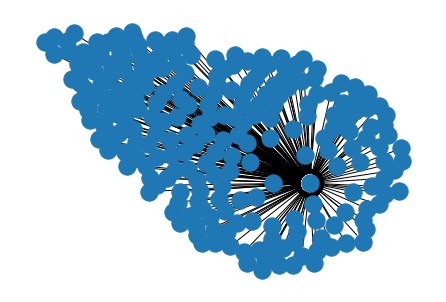

In [29]:
#20 Try to visualise the subgraph of users that have used the 5th most common hashtag
from neo4j import GraphDatabase
import networkx as nx

driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "0000"))

query =f"MATCH p= (u1:User)-[h:USED_HASHTAG]->(h1:Hashtag) WHERE h1.hashtag = '{hashtag_top_20['Hashtag'][4]}' RETURN p"

results = driver.session().run(query)

G = nx.MultiDiGraph()

nodes = list(results.graph()._nodes.values())
for node in nodes:
    G.add_node(node.id, labels=node._labels, properties=node._properties)

rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)
nx.draw(G)
